In [21]:
import numpy as np
from scipy import optimize
import os
import subprocess
from contextlib import contextmanager
import time
import matplotlib.pyplot as plt
import math
from multiprocess import Pool
import random
import json
from copy import deepcopy

First, we'll read in the files created by the Fortran HF code. Things are a little messy thanks to the way I stored things in the past, but they are standard numpy arrays after this cell. Take note of the ordering and suggest a more agreeable choice if you've got an opinion.

In [29]:
@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def spin(spin):
    if(spin==1): return -0.5
    return 0.5

def make_input(params,restart,directory):
    in_template = "../HF/in.template"
    f1 = open(in_template, 'r')
    
    int_string = "&interaction t0={t0},x0={x0},t1={t1},x1={x1},t2={t2},x2={x2},t3={t3},x3={x3},w0={w0},sig={sig},icoul=1,icm=1,j2terms=.true. / \n".format(\
    t0=params["t0"],x0=params["x0"],t1=params["t1"],x1=params["x1"],t2=params["t2"],x2=params["x2"],t3=params["t3"],x3=params["x3"],w0=params["w0"],sig=params["sig"])
    if(restart):
        io_string = "&io printwf=F,printdens=F,restartwf=T,printhpsi=T /"
    else:
        io_string = "&io printwf=T,printdens=F,restartwf=F,printhpsi=F /"
    in_out = directory+"/in"
    f2 = open(in_out, 'w')
    f1.seek(0)
    f2.write(f1.read())
    f2.write(int_string)
    f2.write(io_string)
    f2.write("\n")

    f1.close()
    f2.close()

    return

def run_HF(tag,restart):
    noNaN = 1
    neut = 0
    if(restart == 0):
        os.system("cp in results/in."+tag)
        #print(os.system("../HF/./main"))
        output = subprocess.run(["./main"], capture_output=True)
        #print(output)
        #print(subprocess.run("../HF/./main",shell=True))
        os.system("mv out results/out."+tag)
        os.system("mv wf_numpy.bin results/wf_numpy.bin."+tag)
        noNaN = os.system("grep -q NaN results/out."+tag)
        neut = os.system('grep -q "Total Neutrons =   28.000" results/out.'+tag)
        neut = neut+os.system('grep -q "Total Neutrons =   27.999" results/out.'+tag)
    else:
        output = subprocess.run(["./main"], capture_output=True)
        #os.system("mv out results/out_rst."+tag)
        #os.system("mv hpsi.bin results/hpsi.bin."+tag)
        #print(output)
        #noNaN = os.system("grep -q NaN results/out_rst."+tag)
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        return 1
    if(neut > 256):
        print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        return 1

    return 0


def read_wfs(restartfile):
    #restartfile = '../HF/wf_numpy.bin'

    intchunk = np.dtype(np.int32).itemsize
    realchunk = np.dtype(np.float64).itemsize
    h = np.fromfile(restartfile, dtype=np.float64, count=1, offset=0)[0]
    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+2*intchunk))[0]
#     print("hbox = ", h)
#     print("nbox = ",nbox)
#     print("lmax = ",lmax)
#     print("nmax = ",nmax)

    #sortstates, sortenergies, wfr,
    sortstates = np.fromfile(restartfile, dtype=np.int32, count=nmax*3*2, offset=(realchunk+3*intchunk)).reshape(2,3,nmax)
    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(realchunk+3*intchunk+nmax*3*2*intchunk)).reshape(2,nmax)
    wfs = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(realchunk+3*intchunk+nmax*3*2*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return h,nbox,lmax,nmax,sortstates,sortenergies,wfs

def print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wfs):
    with open(restartfile, 'wb') as file:
        file.write(h)
        file.write(nbox)
        file.write(lmax)
        file.write(nmax)
        file.write(sortstates.reshape((nmax*3*2,)))
        file.write(sortenergies.reshape((nmax*2,)))
        file.write(wfs.reshape((2*2*(lmax+1)*lmax*(nbox+1),)))

    return

def read_hpsi(restartfile):

    intchunk = np.dtype(np.int32).itemsize

    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(2*intchunk))[0]

    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(3*intchunk)).reshape(2,nmax)
    hpsi = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(3*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return sortenergies,hpsi

def get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf,directory):
    restartfile = directory+'/wf_numpy.bin'
    print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    make_input(params,1,directory)
    #with cwd('../HF/'):
    oldpwd=os.getcwd()

    os.chdir(directory)

    errors.append(run_HF("None",1))
    os.chdir(oldpwd)

    restartfile = directory+'/hpsi.bin'
    sortenergies,hpsi = read_hpsi(restartfile)

    return hpsi

def make_wf(coeffs,train_wfs,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_wf = np.zeros(train_wfs[0].shape)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[isospin,2,j]-1
                i_l = states[isospin,1,j]
                i_n = states[isospin,0,j]-1
                trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
    return trial_wf

def galerkin(coeffs,train_wfs,states,levels,params,directory):
    
    #global count
    #global prev_time
    
    #count += 1
    #print("Iteration {}".format(count))
    #print("Iteration time: {}".format(time.time() - prev_time))
    
    #prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,states,sortenergies,trial_wf,directory)
    #hpsi = compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[isospin,2,j]-1
                i_l = states[isospin,1,j]
                i_n = states[isospin,0,j]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = states[isospin,2,j]-1
            i_l = states[isospin,1,j]
            i_n = states[isospin,0,j]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
    #if(count%100 == 0):print(results)
    #if(count%100 == 0):print(coeffs)
            
    return results
def galerkin_min(coeffs,train_wfs,states,levels,params,directory):
    
    global count
    #global prev_time
    
    count += 1
    print("Iteration {}".format(count))
    #print("Iteration time: {}".format(time.time() - prev_time))
    
    #prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,states,sortenergies,trial_wf,directory)
    #hpsi = compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[isospin,2,j]-1
                i_l = states[isospin,1,j]
                i_n = states[isospin,0,j]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = states[isospin,2,j]-1
            i_l = states[isospin,1,j]
            i_n = states[isospin,0,j]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
    if(count%100 == 0):print(coeffs)
    if(count%100 == 0):print(results)
            
    return np.sum(results[:]**2)
def galerkin_wrapper(coeffs,train_wfs,sortstates,levels,params,directory):
    hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-30,'maxfev': 10000, 'band': None, 'eps': None, 'factor': 20, 'diag': None}
    sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,params,directory), method='hybr', options=hybr_dict)
    return sol

def hf_wrapper(params,directory,errors):
    make_input(params,0,directory)
    with cwd(directory):
        errors.append(run_HF("test",0))
    return

def compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    mesh = np.linspace(0, h*(nbox+1), nbox+1)
    mesh[0] = 1e-25
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    sig = 1.0/sig
    e2 = 1.4399784
    pi = 3.141592653589793
    hbar = 6.582119e-22
    hbar22m=20.73553
    A = 48.0
    cmcorr = 1.0 - (1.0/A)
    a0r0 = 3.0/8.0 * t0
    a1r1 = - 1.0/4.0 * t0 * ( 1.0/2.0 + x0 )
    a0s0 = - 1.0/4.0 * t0 * ( 1.0/2.0 - x0 )
    a1s1 = - 1.0/8.0 * t0
    
    a0tau0 = 3.0/16.0 * t1 + 1.0/4.0 * t2 * ( 5.0/4.0 + x2 )
    a1tau1 = - 1.0/8.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    
    a0t0 = - 1.0/8.0 *t1* ( 1.0/2.0 - x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    a1t1 =  1.0/16.0 * (t2-t1)
    
    a0r0p = - 9.0/64.0 * t1 + 1.0/16.0 * t2 *( 5.0/4.0 + x2 )
    a1r1p = 3.0/32.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )

    a0s0p = 3.0/32.0 * t1 * ( 1.0/2.0 - x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )
    a1s1p = 3.0/64.0 * t1 + 1.0/64.0 * t2
    
    cddr0 =  t3 / 16.00
    cddr1 = - 1.0/24.0 * t3 * ( 1.0/2.0 + x3 )
    cdds0 = - 1.0/24.0 * t3 * ( 1.0/2.0 - x3 )
    cdds1 = - 1.0/48.0 * t3
    
    cso0 = - 3.0/4.0 * w0
    cso1 = - 1.0/4.0 * w0
    rho = np.zeros((nbox+1,4))
    tau = np.zeros((nbox+1,4))
    jsc = np.zeros((nbox+1,4))
    for iq in range(2):

        rho[:,iq]=1e-25
        tau[:,iq]=1e-25
        jsc[:,iq]=1e-25
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                #print(iq,s,l,n)
                dwf = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                '''
                for ir in range(1,nbox):
                    tau[ir,iq] = tau[ir,iq] + (2*j+1)*((dwf[ir]\
                    -wf[iq,s,l,n,ir]/mesh[ir])**2+l*(l+1)*(wf[iq,s,l,n,ir]**2)\
                     /mesh[ir]**2)/(4*pi*mesh[ir]**2)

                    rho[ir,iq] = rho[ir,iq] + (2*j+1)*wf[iq,s,l,n,ir]\
                    *wf[iq,s,l,n,ir] / (4*pi*mesh[ir]**2)

                    jsc[ir,iq] = jsc[ir,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                    *wf[iq,s,l,n,ir]**2/(4*pi*mesh[ir]**3)
                '''

                tau[:,iq] = tau[:,iq] + (2*j+1)*((dwf[:]\
                -wf[iq,s,l,n,:]/mesh[:])**2+l*(l+1)*(wf[iq,s,l,n,:]**2)\
                /mesh[:]**2)/(4*pi*mesh[:]**2)

                rho[:,iq] = rho[:,iq] + (2*j+1)*wf[iq,s,l,n,:]\
                *wf[iq,s,l,n,:] / (4*pi*mesh[:]**2)

                jsc[:,iq] = jsc[:,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                *wf[iq,s,l,n,:]**2/(4*pi*mesh[:]**3)
                rho[0,iq] = rho[1,iq]
                tau[1,iq] = tau[2,iq]
                tau[0,iq] = tau[1,iq]


    rho[:,2]=rho[:,0] + rho[:,1]
    rho[0,2] = rho[1,2]
    rho[:,3]=rho[:,0] - rho[:,1]
    tau[:,2]=tau[:,0] + tau[:,1]
    tau[:,3]=tau[:,0] - tau[:,1]
    jsc[:,2]=jsc[:,0] + jsc[:,1]
    jsc[:,3]=jsc[:,0] - jsc[:,1]

    djsc = np.zeros(jsc.shape)
    drho = np.zeros(rho.shape)
    ddrho = np.zeros(rho.shape)
    laprho = np.zeros(rho.shape)

    for iq in range(2):
        for ir in range(nbox+1):
            if(ir < 1):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir+1,iq] - jsc[ir+2,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir+1,iq] + rho[ir+2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir+1,iq]-rho[ir+2,iq])/(12*h**2)
            elif (ir < 2):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir-1,iq] - jsc[ir,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir,iq])/(12*h**2)
            elif ((ir >= 2) and (ir <= nbox-2)):
                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir-2,iq])/(12*h)

                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 -8*jsc[ir-1,iq] + jsc[ir-2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir-2,iq])/(12*h**2)
            elif ((ir > nbox-2) and (ir!=nbox)):
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
            else:
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
        ddrho[0:3,iq]=ddrho[4,iq]

    drho[:,2] = drho[:,0] + drho[:,1]
    drho[:,3] = drho[:,0] - drho[:,1]
    djsc[:,2] = djsc[:,0] + djsc[:,1]
    djsc[:,3] = djsc[:,0] - djsc[:,1]
    ddrho[:,2] = ddrho[:,0] + ddrho[:,1]
    ddrho[:,3] = ddrho[:,0] - ddrho[:,1]
    for i in range(4):
        laprho[:,i] = ddrho[:,i] + 2./mesh[:]*drho[:,i]

    uc = np.zeros((nbox+1,2))
    ucso = np.zeros((nbox+1,2))
    umr = np.zeros((nbox+1,2))
    dumr = np.zeros((nbox+1,2))
    d2umr = np.zeros((nbox+1,2))
    udd = np.zeros((nbox+1,2))
    uso = np.zeros((nbox+1,2))
    ucoul = np.zeros((nbox+1))

    for iq in range(2):
        '''
        for ir in range(nbox+1):

            #Central Field U(r)
            uc[ir,iq] = 2*(a0r0-a1r1)*rho[ir,2] + 4*a1r1 * rho[ir,iq]  \
                           + (a0tau0-a1tau1) *tau[ir,2]+ 2 *a1tau1*tau[ir,iq] \
                           +2*( a0r0p-a1r1p )*laprho[ir,2] + 4 *a1r1p * laprho[ir,iq]
            #Part of U(r) coming from so)
            ucso[ir,iq] = (cso0-cso1 ) *(djsc[ir,2] + 2 * jsc[ir,2]/mesh[ir] ) \
                             + 2 *cso1 * ( djsc[ir,iq] + 2 * jsc[ir,iq] / mesh[ir] )
            #Mq(r) contributions
            umr[ir,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[ir,2] + 2 * a1tau1*rho[ir,iq]
            dumr[ir,iq] = (a0tau0-a1tau1)*drho[ir,2] + 2 * a1tau1*drho[ir,iq]
            d2umr[ir,iq] = (a0tau0-a1tau1)*ddrho[ir,2] + 2 * a1tau1*ddrho[ir,iq]
            # t3 part of U(r)
            udd[ir,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[ir,2]**(sig+1)  \
                            +2*sig*cddr1*(rho[ir,0]**2+rho[ir,1]**2)*rho[ir,2]**(sig-1.) \
                            + 4 * cddr1 * rho[ir,iq] * rho[ir,2]**sig
            #spin-orbit part
            uso[ir,iq] = - (cso0-cso1 )*drho[ir,2]/mesh[ir] \
                             - 2 *cso1 * drho[ir,iq] / mesh[ir]
            if (True):
                uso[ir,iq] = uso[ir,iq]-(a0t0-a1t1) *jsc[ir,2] / mesh[ir] \
                             - 2 *a1t1 * jsc[ir,iq] / mesh[ir]
            #coulomb
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)

                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
        '''
        #Central Field U(r)
        uc[:,iq] = 2*(a0r0-a1r1)*rho[:,2] + 4*a1r1 * rho[:,iq]  \
                       + (a0tau0-a1tau1) *tau[:,2]+ 2 *a1tau1*tau[:,iq] \
                       +2*( a0r0p-a1r1p )*laprho[:,2] + 4 *a1r1p * laprho[:,iq]
        #Part of U(r) coming from so)
        ucso[:,iq] = (cso0-cso1 ) *(djsc[:,2] + 2 * jsc[:,2]/mesh[:] ) \
                         + 2 *cso1 * ( djsc[:,iq] + 2 * jsc[:,iq] / mesh[:] )
        #Mq(r) contributions
        umr[:,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[:,2] + 2 * a1tau1*rho[:,iq]
        dumr[:,iq] = (a0tau0-a1tau1)*drho[:,2] + 2 * a1tau1*drho[:,iq]
        d2umr[:,iq] = (a0tau0-a1tau1)*ddrho[:,2] + 2 * a1tau1*ddrho[:,iq]
        # t3 part of U(r)
        udd[:,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[:,2]**(sig+1)  \
                        +2*sig*cddr1*(rho[:,0]**2+rho[:,1]**2)*rho[:,2]**(sig-1.) \
                        + 4 * cddr1 * rho[:,iq] * rho[:,2]**sig
        #spin-orbit part
        uso[:,iq] = - (cso0-cso1 )*drho[:,2]/mesh[:] \
                         - 2 *cso1 * drho[:,iq] / mesh[:]
        if (True):
            uso[:,iq] = uso[:,iq]-(a0t0-a1t1) *jsc[:,2] / mesh[:] \
                         - 2 *a1t1 * jsc[:,iq] / mesh[:]
        #coulomb
        for ir in range(nbox+1):
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)
    
                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
    hpsi = np.zeros(wf.shape)
    #dwf = np.zeros(rho[:,0].shape)
    ddwf = np.zeros(rho[:,0].shape)
    for iq in range(2):
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''
        for s in range(2):
            for l in range(lmax):
                j = l + spin(s+1)
                if (l==0): j=0.5

                for n in range(0,2):
                    dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                    ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                    hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                    if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''


    return hpsi

def derivative_sca(wf,nbox,l):
    dwf = np.zeros(wf.shape)
    boundary_condition = 2
    h_12 = h*12.00
    h_60 = h*60.00
    sig = ( l%2 - 0.50 ) * 2
    dwf[0] = ( 8.00 * wf[1] - wf[2] + sig * wf[0] ) / h_12
    dwf[1] = ( 45.00 * ( wf[2] - wf[0] ) - 9.00 * wf[3] \
         + wf[4] - sig * wf[0] ) / h_60
    dwf[2] = ( 45.00 * ( wf[3] - wf[1] ) - 9.00 * ( wf[4] - wf[0] ) \
         + wf[5] ) / h_60
    
    if ( boundary_condition == 0 or  \
        (boundary_condition == 2 and l%2 == 0) or \
        (boundary_condition == 3 and l != 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( -8.00 * wf[nbox-2] + wf[nbox-1] + wf[nbox-3] ) / h_12
        dwf[nbox-2] = ( 45.00 * ( wf[nbox-1] - wf[nbox-3] ) + 9.00 * wf[nbox-4] \
            - wf[nbox-1] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.00 * ( wf[nbox-2] - wf[nbox-4] ) \
            - 9.00 * ( wf[nbox-1] - wf[nbox-5] ) - wf[nbox-6] ) / h_60
        
    if ( boundary_condition == 1 or  \
        (boundary_condition == 2 and l%2 != 0) or \
        (boundary_condition == 3 and l == 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( - 54.0 * wf[nbox-2] + 45.0 * wf[nbox-1] + 10.0 * wf[nbox-3] - wf[nbox-4] ) / h_60
        dwf[nbox-2] = ( 36.0 * wf[nbox-1] + wf[nbox-2] - 45.0 * wf[nbox-3] \
            + 9.0 * wf[nbox-4] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.0 * ( wf[nbox-2] - wf[nbox-4] ) - 8.0 * wf[nbox-1]  \
            + 9.0 * wf[nbox-5] - wf[nbox-6] ) / h_60
    
    for i in range(3,nbox-4):
        dwf[i] = ( 45.00 * ( wf[i+1] - wf[i-1] )  \
            - 9.00 * ( wf[i+2] - wf[i-2] ) \
            + wf[i+3] - wf[i-3] ) / h_60
    return dwf

def NM_to_t(nm_params):
    c13=1.0/3.0
    c23=2.0/3.0
    #VMASS =   1.249838574232270 UNEDF1
    VMASS = 1.25000101440918243
    kfconst =(1.50*math.pi**2)**(1.0/3.0)    # (3Pi^2/2)^(1/3)
    CK      = 3.0/5.0*kfconst**2
    hbzero   =   20.735530000000000
    mpi=   138.03/197.3
    #E,K,SMASS,RHO,ASS,LASS, Crdr, CrdJ
    E = nm_params["E"]
    K = nm_params["K"]
    SMASS = nm_params["SMASS"]
    RHO = nm_params["RHO"]
    ASS = nm_params["ASS"]
    LASS = nm_params["LASS"]
    Crdr = nm_params["Crdr"]
    CrdJ = nm_params["CrdJ"]
    tauc=CK*RHO**c23
    u=(kfconst/mpi)*RHO**c13
    rho2=RHO**2
    Crho = [0.0,0.0]
    Cdrho = [0.0,0.0]
    Ctau = [0.0,0.0]
    # set/calculate sigma
    sigma=((1.0/3.0)*(-K+tauc*hbzero*(-3.0+4.0*SMASS)-9.0*E)) \
             /(tauc*hbzero*(-3.0+2.0*SMASS)+3.0*E)
    
    Crho[0]=(c13*(tauc*hbzero*(-3.0+(2.0-3.0*sigma)*SMASS) \
        +3.0*(1.0+sigma)*E))/(sigma*RHO)
    Cdrho[0]=(c13*RHO**(-1.0-sigma)*(tauc*hbzero*(3.0-2.0*SMASS)\
        -3.0*E))/sigma
    Ctau[0]=(hbzero*(SMASS-1.0))/RHO
    
    Crho[1]=(27.0*ASS*(1.0+sigma)-9.0*LASS \
        +5.0*tauc*hbzero*(5.0-6.0*VMASS+3.0*sigma*(-4.0+3.0*VMASS)) \
        +RHO*(40.0*tauc*Ctau[0]-60.0*tauc*sigma*Ctau[0]))/(27.0*sigma*RHO)
    Cdrho[1]=-(RHO**(-1.0-sigma)*(27.0*ASS-9.0*LASS \
        +5.0*tauc*hbzero*(5.0-6.0*VMASS) \
        +40.0*tauc*RHO*Ctau[0]))/(27.0*sigma)
    Ctau[1]=(hbzero-hbzero*VMASS+RHO*Ctau[0])/RHO
    
    t0  =  (8.0/3)*Crho[0]
    t1  =  4.0/3.0*(Ctau[0]-4.0*Crdr[0])
    t2  =  4.0/3.0*(3.0*Ctau[0]-6.0*Ctau[1]+4.0*Crdr[0]-8.0*Crdr[1])
    t3  =  16.0*Cdrho[0]
    x0  = -0.50*(3.0*Crho[1]/Crho[0]+1.0)
    x1  =  2.0*(-Ctau[0]-3.0*Ctau[1]+4.0*Crdr[0]+12.0*Crdr[1])/t1/3.0
    x2  = -2.0*(3.0*Ctau[0]-15.0*Ctau[1]+4.0*Crdr[0]-20.0*Crdr[1])/t2/3.0
    x3  = -0.50*(3.0*Cdrho[1]/Cdrho[0]+1.0)
    t4  =  (CrdJ[1]-CrdJ[0]) / 2.0
    t4p = -CrdJ[1]*4.0
    t_params = {"t0":t0,"x0":x0,"t1":t1,"x1":x1,"t2":t2,"x2":x2,"t3":t3,"x3":x3,"w0":t4p,"sig":1/sigma}
    #print(t_params)
    return t_params

def radius(isospin,sortstates,h,wf):
    nbox = len(wf[0,0,0,0,:])
    mesh = np.linspace(0, h*(nbox-1), nbox)
    mesh[0] = 1e-25
    iq = isospin
    rho = np.zeros(mesh.shape)
    for i in range(nmax):
        if(sortstates[iq,2,i]<1): continue
        n = sortstates[iq,0,i]-1
        l = sortstates[iq,1,i]
        s = sortstates[iq,2,i]-1
        j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
        if (sortstates[iq,1,i] == 0): j = 0.5
        #print(iq,s,l,n)

        rho[:] = rho[:] + (2*j+1)*wf[iq,s,l,n,:]\
        *wf[iq,s,l,n,:] / (4*math.pi*mesh[:]**2)
    npart = np.sum(4*math.pi*h*mesh[:]**2*rho[:])
    radius = np.sqrt(4*math.pi*h*sum(mesh[:]**4 * rho[:])/npart)

    return radius

The following cell defines a list of parameters (only one right now) and then loops over those parameters and runs the HF code to generate outputs and WFs.

The inputs, outputs, and WFs are copied to a results folder (this can be changed) with some tag appended to the file name. In the future we may want to change how this tag is generated.

In [124]:
# params = [[-2483.45,13757.0],\
#           [-2503.45,13757.0],\
#           [-2353.45,14757.0],\
#           [-2583.45,12757.0],\
#           [-2383.45,13457.0],]

#default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
#nmdefault_params = {"E":-15.9843259547113412,"K":229.905998768288782,"SMASS":1.43365799002626937,"RHO":0.160573718963025164,"ASS":32.0099875506415614,"LASS":48.1461992412703239,"Crdr":[-76.793125,17.0058521875],"CrdJ":[-93.75,-31.25]}
os.chdir('/home/kyle/code/GalerkinEC/EC')
nmdefault_params = {"E":-15.8,"K":220.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":40.004790480413600,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]}
nmparams = [\
        {"E":-16.5,"K":160.0,"SMASS":0.7,"RHO":0.14,"ASS":32.0,"LASS":30.0,"Crdr":[-40.0,-90.0],"CrdJ":[-55.0,-50.0]},\
        {"E":-14.5,"K":260.0,"SMASS":1.4,"RHO":0.18,"ASS":26.0,"LASS":120.0,"Crdr":[-55.0,-165.0],"CrdJ":[-105.0,-15.0]},\
        #{"E":-16.5,"K":260.0,"SMASS":1.4,"RHO":0.14,"ASS":32.0,"LASS":120.0,"Crdr":[-55.0,-90.0],"CrdJ":[-55.0,-15.0]},\
        #{'E': -16.274874329204067, 'K': 258.79079847430086, 'SMASS': 1.3776100351675147, 'RHO': 0.17816598326132066, 'ASS': 29.318445701835522, 'LASS': 79.91276455934667, 'Crdr': [-43.80470978861703, -112.22596435322328], 'CrdJ': [-61.93864886973122, -46.09417700082186]},\
        #{"E":-14.5,"K":160.0,"SMASS":0.7,"RHO":0.18,"ASS":26.0,"LASS":30.0,"Crdr":[-50.0,-125.0],"CrdJ":[-85.0,-25.0]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":30.0,"Crdr":[-60.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-200.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":50.0,"Crdr":[-55.0,-190.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        ]
#nmparams = [\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":28.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":28.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":30.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":30.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":30.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":28.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":250.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":27.0,"LASS":20.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":190.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":32.0,"LASS":140.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
#        ]

errors = []
params = []
directory = '../HF'
for i in range(len(nmparams)):
    params.append(NM_to_t(nmparams[i]))
    make_input(params[i],0,directory)
    with cwd('../HF/'):
        errors.append(run_HF(str(i),0))

default_params = NM_to_t(nmdefault_params)
make_input(default_params,0,directory)
#with cwd('../HF/'):
#    errors.append(run_HF("default",0))

restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)


Now we read the files back in and print the energies of the single particle states to see whats up.

In [125]:
'''
default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)
params = [\
          {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":514.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":454.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13957.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
         ]
errors = [0,0,0,0,0,0,0]
'''
train_wfs = []
states = []
energies = []
defenergies=[]
levels = [0,0]
for i in range(len(params)):
    if(errors[i] == 1): continue
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates_t,sortenergies,wf = read_wfs(restartfile)
    train_wfs.append(wf)
    states.append(sortstates)
    directory='../HF'
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf,directory)
    dhpsi = get_hpsi(default_params,h,nbox,lmax,nmax,sortstates,sortenergies,wf_default,directory)

    #Calculate energies as a test for levels
    energy = [[],[]]
    for isospin in range(2):
        occupied = 0
        for i in range(lmax):
            level = i
            i_s = sortstates[isospin,2,level]-1
            i_l = sortstates[isospin,1,level]
            i_n = sortstates[isospin,0,level]-1
            if(i_s < 0): continue
            occupied += 1
            sp_en = np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])
            defsp_en = np.sum(-h*wf_default[isospin,i_s,i_l,i_n,:]*dhpsi[isospin,i_s,i_l,i_n,:])
            energy[isospin].append(sp_en)
            defenergies.append(defsp_en)
            #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
            #print("Energy: {}".format(energy[isospin][i]))
        levels[isospin] = occupied
    energies.append(energy)
defenergies = defenergies[:levels[0]+levels[1]]
#h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs()
# npart = 0
# for i in range(nmax):
#     if(sortstates[0,0,i]>0):
#         nfill = int(2*(sortstates[0,1,i]+spin(sortstates[0,2,i])) + 1)
#         if (sortstates[0,1,i] == 0): nfill = 2
#         npart += nfill
#         print(npart)

Now we can calculate the hpsi (or, G) objects from Wfs. Here I am reading in training Wfs just as a test.

In [ ]:
for i in range(len(params)):
    if(errors[i] == 1): continue
    # The following is to simply read in the trial WFs during testing
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs(restartfile)

    # get hpsi
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    occupied = 0
    for i in range(nmax):
        isospin = 0
        level = i
        i_s = sortstates[isospin,2,level]-1
        i_l = sortstates[isospin,1,level]
        i_n = sortstates[isospin,0,level]-1
        if(i_s < 0): continue
        occupied += 1
        #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
        #print("Energy: {}".format(np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])))

#print("There are {} occupied levels!".format(occupied))

In [8]:
global count
count = 0

start_time = time.time()
global prev_time 
prev_time = time.time()

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states".format(train_num,sum(levels)))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
coeffs[0:train_num*sum(levels)] = 1/train_num
#coeffs[0:sum(levels)] = 1.0
coeffs[train_num*sum(levels):] = 25.0
#coeffs = sol.x
tag = "test"
directory = '/mnt/ram/HF.'+tag
os.system("mkdir -p {directory}".format(directory=directory))
os.chdir("/home/kyle/code/GalerkinEC/EC")

os.system("cp ../HF/main {directory}/.".format(directory=directory))
#coeffs = sol.x
nmtest_params = {"E":-15.9843259547113412,"K":215.905998768288782,"SMASS":1.43365799002626937,"RHO":0.160573718963025164,"ASS":32.0099875506415614,"LASS":57.1461992412703239,"Crdr":[-76.793125,17.0058521875],"CrdJ":[-93.75,-31.25]}
nmtest_params = {"E":-15.8,"K":220.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":40.004790480413600,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]}
test_params = NM_to_t(nmtest_params)
#print(nm_sampleparams[0])
#galerkin(coeffs,wfs,states,levels,test_params)
def funcOpt(xk):
    global sortstates
    global levels
    global test_params
    global directory
    global train_wfs
    res = galerkin(xk,train_wfs,sortstates,levels,test_params,directory)
    print(np.sum(res[:]**2))
    print(res)
    return
hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-30,'maxfev': 5000, 'band': None, 'eps': None, 'factor': 100, 'diag': None}
#minsol = optimize.minimize(galerkin_min,coeffs, args=(train_wfs,sortstates,levels,test_params,directory),method='BFGS',callback=funcOpt,options={'disp':True,'return_all':True})
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='df-sane',options={"maxfev":1000,"disp":True,'line_search': 'cruz'})#, options=hybr_dict)
# Krylov methods: {‘lgmres’, ‘gmres’, ‘bicgstab’, ‘cgs’, ‘minres’}, default lmgres
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='krylov',options={"disp":True,"fatol":6e-6,"nit":20,'jac_options':{'method':'lgmres'}})#, options=hybr_dict)
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='lm',options={"maxiter":5000,'xtol': 1.49012e-16})#, options=hybr_dict)
sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='hybr', options=hybr_dict)
minsol = sol
print(minsol.x)
print(galerkin(minsol.x,train_wfs,sortstates,levels,test_params,directory))
print("Total time took: {}".format(time.time()-start_time))

Training with 2 WFs, each one with 13 total states
[ 0.43739036  0.40398244  0.42870413  0.37683275  0.08453831  0.39280859
  0.78922607  0.49182208  0.44744305  0.43009673  0.44777583  0.53152881
 -0.18000191  0.56502159  0.59981509  0.57322888  0.62507755  0.91712866
  0.60958673  0.21087721  0.51376143  0.55526802  0.57429923  0.55366356
  0.47059171  1.17221946 36.56510921 27.367817   25.57490344 17.81651719
 15.64646216 14.38222884  8.20241733 37.85191795 29.7273594  29.15501947
 19.3949322  19.10626907 15.73603434]
[-7.22446336e-03 -4.99873923e-06  2.74274259e-04 -8.65604905e-05
 -9.68656919e-03 -1.06547612e-03  1.42230652e-03  9.70646324e-04
  2.72020215e-04 -3.57619969e-04 -1.06329606e-03 -1.01127283e-03
 -2.39806189e-02  8.48814125e-03  1.02369723e-03  1.03136528e-04
  7.77229325e-04  8.91001650e-03  1.54194789e-03 -3.14979473e-04
  2.98783479e-04 -8.65433465e-04 -2.80071893e-04 -3.53636918e-04
 -4.32532872e-04  2.25123356e-02  5.53265362e-06 -1.38205937e-04
  3.55436889e-05 -

In [9]:
# Make the test WF with test_params
os.system("mkdir -p {directory}/results".format(directory=directory))

make_input(test_params,0,directory)
with cwd(directory):
    errors.append(run_HF("test",0))


In [11]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(minsol.x,train_wfs,sortstates,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,directory)
# Read in the cheated test
restartfile = directory+'/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf,directory)
#test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
print("conv= 1e-12, h= {}".format(h))
for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial:.2f} Test: {test:.2f} Difference: {diff:.2e} Norm: {norm:.4e}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=(1.0-norm)))



conv= 1e-12, h= 0.01
Trial: -36.57 Test: -36.73 Difference: -4.56e-03 Norm: 2.7883e-05
Trial: -27.36 Test: -27.38 Difference: -3.96e-04 Norm: 8.7003e-05
Trial: -25.58 Test: -25.75 Difference: -6.95e-03 Norm: 1.4200e-05
Trial: -17.81 Test: -17.71 Difference: 5.87e-03 Norm: 9.3530e-05
Trial: -15.65 Test: -15.56 Difference: 6.11e-03 Norm: 2.0302e-03
Trial: -14.38 Test: -14.39 Difference: -4.95e-04 Norm: 5.7143e-05
Trial: -8.20 Test: -8.09 Difference: 1.42e-02 Norm: 1.9388e-04
Trial: -37.85 Test: -37.76 Difference: 2.36e-03 Norm: 8.5836e-05
Trial: -29.73 Test: -29.92 Difference: -6.13e-03 Norm: -7.5975e-06
Trial: -29.16 Test: -29.11 Difference: 1.63e-03 Norm: 8.6802e-05
Trial: -19.40 Test: -19.76 Difference: -1.89e-02 Norm: -3.2674e-05
Trial: -19.11 Test: -19.22 Difference: -5.70e-03 Norm: 9.9785e-06
Trial: -15.74 Test: -16.07 Difference: -2.12e-02 Norm: 1.5753e-02


In [ ]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(minsol.x,train_wfs,sortstates,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,directory)
# Read in the cheated test
restartfile = directory+'/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf,directory)
#test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
print("conv= 1e-12, h= {}".format(h))
for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial:.2f} Test: {test:.2f} Difference: {diff:.2e} Norm: {norm:.4f}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))



conv= 1e-12, h= 0.01
Trial: -38.32 Test: -36.73 Difference: 4.14e-02 Norm: 0.9997
Trial: -28.48 Test: -27.38 Difference: 3.87e-02 Norm: 0.9995
Trial: -27.11 Test: -25.75 Difference: 5.01e-02 Norm: 0.9996
Trial: -18.16 Test: -17.71 Difference: 2.48e-02 Norm: 0.9994
Trial: -15.84 Test: -15.56 Difference: 1.80e-02 Norm: 0.9989
Trial: -15.28 Test: -14.39 Difference: 5.84e-02 Norm: 0.9995
Trial: -8.05 Test: -8.09 Difference: -5.09e-03 Norm: 0.9994
Trial: -36.56 Test: -37.76 Difference: -3.29e-02 Norm: 1.0000
Trial: -29.07 Test: -29.92 Difference: -2.92e-02 Norm: 0.9999
Trial: -28.53 Test: -29.11 Difference: -2.03e-02 Norm: 1.0000
Trial: -19.45 Test: -19.76 Difference: -1.62e-02 Norm: 0.9999
Trial: -19.26 Test: -19.22 Difference: 1.98e-03 Norm: 0.9999
Trial: -16.09 Test: -16.07 Difference: 9.96e-04 Norm: 0.9999


In [219]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(sol.x,train_wfs,sortstates,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,directory)
# Read in the cheated test
restartfile = directory+'/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf,directory)
#test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
print("conv= 1e-8, h= {}".format(h))
for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))

conv= 1e-8, h= 0.01
Trial: -36.72852280238576 Test: -36.73372908594549 Difference: -0.00014175042072183633 Norm: 1.0000063710836815
Trial: -27.377250070620377 Test: -27.3754892867538 Difference: 6.431558545997446e-05 Norm: 0.9999971246060901
Trial: -25.75154677413168 Test: -25.753615723232365 Difference: -8.034271179251604e-05 Norm: 0.9999989027490409
Trial: -17.709463829476395 Test: -17.709556618124253 Difference: -5.239495037908119e-06 Norm: 0.9999965433823823
Trial: -15.545477014489652 Test: -15.557604994372548 Difference: -0.0007801613209804942 Norm: 1.0000062374259462
Trial: -14.387120672781363 Test: -14.388750363756484 Difference: -0.00011327429665652705 Norm: 0.999995817629757
Trial: -8.08536833300592 Test: -8.086142563082037 Difference: -9.575693329339933e-05 Norm: 0.9999994842074678
Trial: -37.762138413899606 Test: -37.76459496325062 Difference: -6.505323729528187e-05 Norm: 1.000000545145368
Trial: -29.914046692228286 Test: -29.91518965205888 Difference: -3.820813152946456e-05

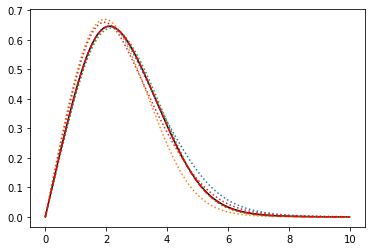

In [80]:
fig = plt.figure()
ax = plt.axes()

isospin = 0
i_s = 0
i_l = 0
i_n = 0

x = np.linspace(0, 20, 2001)
ax.plot(x[:1000],trial_wf[isospin,i_s,i_l,i_n,:1000],color='black')
for i in range(len(train_wfs)):
    ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000],linestyle=":")
ax.plot(x[:1000],test_wf[isospin,i_s,i_l,i_n,:1000],linestyle='--',color='red')

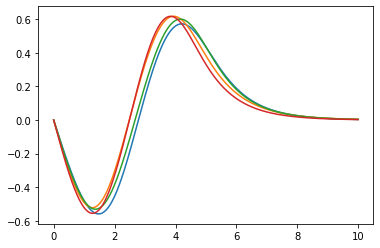

In [92]:
fig = plt.figure()
ax = plt.axes()
train_num = len(train_wfs)
tot_levels = sum(levels)
train = 6
for i in range(train_num):
    for isospin in range(1,2):
        for j in range(5,6):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000])#,linestyle='--',color='red')
            #trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
            #    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]

In [126]:
# Let's get some stats!

samples = 500
dirs = []
nm_sampleparams = []
sampleparams = []
hf_args = []

sample_args = [] #(coeffs,train_wfs,sortstates,levels,test_params,directory)

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states over {} samples".format(train_num,sum(levels),samples))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
coeffs[0:train_num*sum(levels)] = 1.0/train_num
#coeffs[0:sum(levels)] = 1.0
coeffs[train_num*sum(levels):] = 25.0
nm_sampleparams = []
testerrors = []
with open('nm_params_all.json') as f:
    for line in f:
        nm_sampleparams.append(json.loads(line))
for i in range(samples):
    directory = '/mnt/ram/HF.{}'.format(i)
    dirs.append(directory)
    os.system("mkdir -p {directory}".format(directory=directory))
    os.system("cp ../HF/main {directory}/.".format(directory=directory))
    os.system("mkdir -p {directory}/results".format(directory=directory))
    # nmparam = nmdefault_params

    # nmparam["E"] = random.uniform(-16.5,-14.5)
    # nmparam["K"] = random.uniform(160.0,260.0)
    # nmparam["SMASS"] = random.uniform(0.7,1.4)
    # nmparam["RHO"] = random.uniform(0.14,0.18)
    # nmparam["ASS"] = random.uniform(26.0,32.0)
    # nmparam["LASS"] = random.uniform(30.0,120.0)
    # nmparam["Crdr"][0] = random.uniform(-55.0,-40.0)
    # nmparam["Crdr"][1] = random.uniform(-165.0,-90.0)
    # nmparam["CrdJ"][0] = random.uniform(-105.0,-55.0)
    # nmparam["CrdJ"][1] = random.uniform(-50.0,-15.0)
    nmparam = deepcopy(nm_sampleparams[i])
    #nm_sampleparams.append(deepcopy(nmparam))

    sampleparams.append(NM_to_t(nmparam))

    sample_args.append((coeffs,train_wfs,sortstates,levels,NM_to_t(nmparam),directory))

    hf_args.append((NM_to_t(nmparam),directory,testerrors))



# with open('nm_params_all.json', 'w') as fout:
#     for dict in nm_sampleparams:
#         print(dict)
#         json.dump(dict, fout)
#         fout.write("\n")

# optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='hybr', options=hybr_dict)
procs = 12
with Pool(procs) as p:
    sampled_out = p.starmap(galerkin_wrapper,sample_args)

#with Pool(procs) as p:
#    p.starmap(hf_wrapper,hf_args)

Training with 2 WFs, each one with 13 total states over 500 samples


In [127]:
esp_errors = []
norm_errors = []
defdiffs = []
#optfile = open('train_4_coeffs_all.bin',mode='wb')
tradii = []
gradii = []
dradii = []
nrad_avg = 0
prad_avg = 0
ndiffrad = 0
pdiffrad = 0
os.chdir('/home/kyle/code/GalerkinEC/EC')
goodcount = 0
#cofs = np.zeros((train_num*sum(levels) + sum(levels)))
norms = 0.0

for i in range(len(sampled_out)):
    # for cof in sampled_out[i].x:
    #     optfile.write(cof)
    restartfile = dirs[i]+'/results/wf_numpy.bin.test'

    noNaN = 1
    neut = 0
    conv = 1
    
    noNaN = os.system("grep -q NaN {}/results/out.test".format(dirs[i]))
    conv = os.system('grep -q "Iteration:         300" {}/results/out.test'.format(dirs[i]))
    neut = os.system('grep -q "Total Neutrons =   28.000" {}/results/out.test'.format(dirs[i]))
    neut = neut+os.system('grep -q "Total Neutrons =   27.999" {}/results/out.test'.format(dirs[i]))
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        continue
    if(conv==0):
        print("took 300 iterations in run {tag}!".format(tag=tag))
        continue
    if(neut > 256):
        print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        continue
    goodcount += 1

    #print(galerkin(sampled_out[i].x,train_wfs,sortstates,levels,sampleparams[i],dirs[i]))
    # Make trial WF and hpsi with solved coeffs
    #cofs = np.fromfile(optfile, dtype=np.float64, count=(train_num*sum(levels) + sum(levels)), offset=i*sol.x.nbytes)
    #print(cofs)
    
    
    trial_wf = make_wf(sampled_out[i].x,train_wfs,sortstates,levels)
    #trial_wf = make_wf(cofs,train_wfs,sortstates,levels)
    trial_hpsi = get_hpsi(sampleparams[i],h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,dirs[i])
    # Read in the cheated test
    restartfile = dirs[i]+'/results/wf_numpy.bin.test'

    h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
    test_hpsi = get_hpsi(sampleparams[i],h,nbox,lmax,nmax,sorts,sorte,test_wf,dirs[i])
    tradii.append([radius(0,sortstates,h,test_wf),radius(1,sortstates,h,test_wf)])
    gradii.append([radius(0,sortstates,h,trial_wf),radius(1,sortstates,h,trial_wf)])
    dradii.append([radius(0,sortstates,h,wf_default),radius(1,sortstates,h,wf_default)])
    #test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
    ediff = 0.0
    defdiff = 0.0
    for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = sortstates[isospin,2,j]-1
                i_l = sortstates[isospin,1,j]
                i_n = sortstates[isospin,0,j]-1
                norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
                #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
                trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
                test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
                ediff += abs((trial_sp-test_sp)/test_sp)
                defdiff += abs((defenergies[isospin*levels[0] + j]-test_sp)/defenergies[isospin*levels[0] + j])
                norms += abs(1.0-norm)
                norm_errors.append(abs(1.0-norm))
                #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
                #print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))
    eavg = ediff/(levels[0]+levels[1])
    j = goodcount - 1
    nrad_avg += abs((tradii[j][0]-gradii[j][0])/tradii[j][0])
    #nrad_avg += abs(((tradii[i][0]-tradii[i][1])-(gradii[i][0]-gradii[i][1]))/(tradii[i][0]-tradii[i][1]))/samples

    prad_avg += abs((tradii[j][1]-gradii[j][1])/tradii[j][1])
    ndiffrad += abs((tradii[j][0]-dradii[j][0])/dradii[j][0])
    #ndiffrad += abs(((tradii[i][0]-tradii[i][1])-(dradii[i][0]-dradii[i][1]))/(dradii[i][0]-dradii[i][1]))/samples

    pdiffrad += abs((tradii[j][1]-dradii[j][1])**2/dradii[j][1])
    #print("Average SP E Errors {}".format(eavg))
    diffavg = defdiff/(levels[0]+levels[1])
    #print("Average SP Differences {}".format(diffavg))
    defdiffs.append(diffavg)
    if(goodcount-1 == 251):
        print(i,eavg)
        print(nm_sampleparams[i])
    esp_errors.append(eavg)
    #print("Sum of Norm Errors {}".format(norms))

#optfile.close()
print("{} Total Good Runs".format(goodcount))
print("Total Average Norm Error: {}".format(norms/(goodcount*(levels[0]+levels[1]))))
print("Total Average S.P. Energy Error: {}".format(sum(esp_errors)/goodcount))
print("Total Average S.P. Energy Diffs: {}".format(sum(defdiffs)/goodcount))
print("Total Average Neutron Radius Error: {}".format(nrad_avg/goodcount))
print("Total Average Proton Radius Error: {}".format(prad_avg/goodcount))
print("Total Average Neutron Radius Diff: {}".format(ndiffrad/goodcount))
print("Total Average Proton Radius Diff: {}".format(pdiffrad/goodcount))


took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
NaNs in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
NaNs in run test!
NaNs in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
NaNs in run test!
took 300 iterations in run test!
took 300 iterations in run test!
NaNs in run test!
took 300 iterations in run test!
NaNs in run test!
NaNs in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
took 300 iterations in run test!
NaNs in run test

5213
8.66983867063622
8.66983867063622
5213
0.0016631188702544064


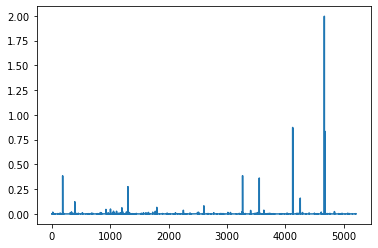

In [123]:
fig = plt.figure()
ax = plt.axes()
ax.plot(norm_errors)
print((goodcount*(levels[0]+levels[1])))
print(norms)
print(sum(norm_errors))
print(len(norm_errors))
print(sum(norm_errors)/(len(norm_errors)))
